In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from gdc.data_access import *

(8712, 10000) (8760,)


<Axes: xlabel='time'>

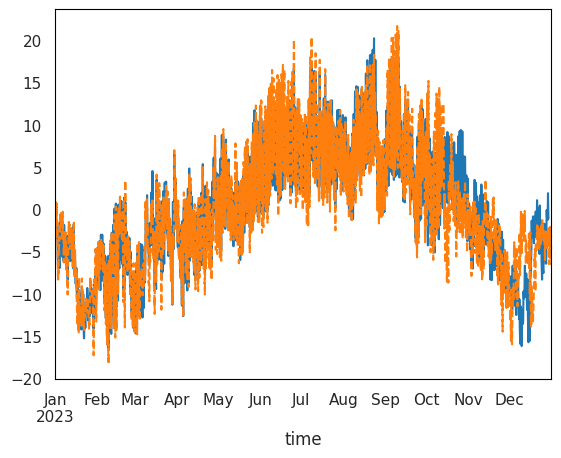

In [2]:
# aligned temperatures
print(df_temp_simulated_normalized.shape, df_temp_real[CB.temp].shape)
demean(df_temp_simulated_normalized.mean(axis=1)).plot()
demean(df_temp_real[CB.temp]).plot()

<Axes: xlabel='datetime'>

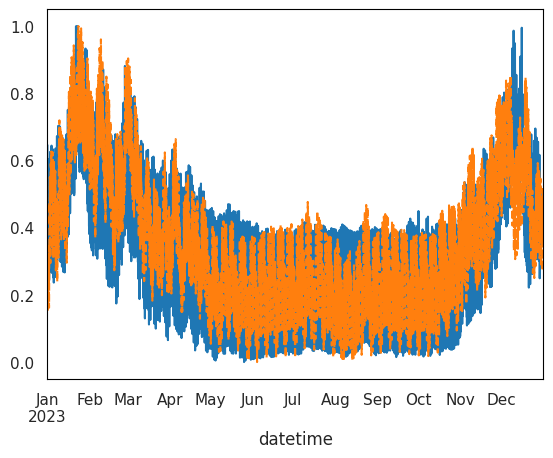

In [3]:
# aligned loads

to_zero_one(df_load_simulated_normalized.mean(axis=1)).plot()
to_zero_one(df_hourly_load_real[CB.cons]).plot()

In [4]:
# labels
print(df_labels.shape)
df_labels.head()

(10000, 2)


,Power,ToU
0,6,0
1,6,0
2,6,0
3,6,0
4,6,0


<Axes: xlabel='date'>

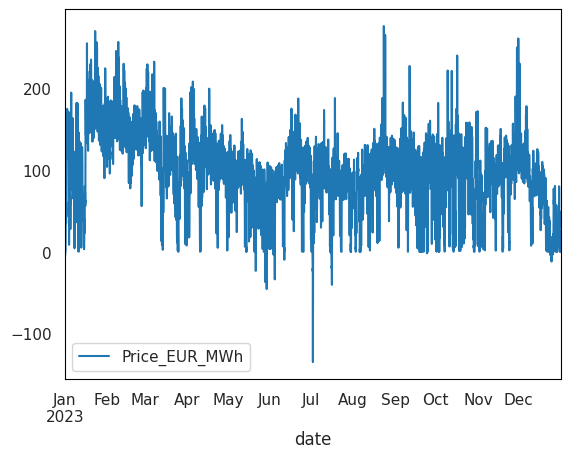

In [5]:
# prices 

df_hourly_prices.plot()

In [6]:
df_hourly_prices.head()

,Price_EUR_MWh
date,
2023-01-01 00:00:00,-0.10
2023-01-01 01:00:00,-1.33
2023-01-01 02:00:00,-4.08
2023-01-01 03:00:00,-4.16
2023-01-01 04:00:00,-3.58


In [7]:
# merged series

In [8]:
df_merged_real.shape

(8760, 12)

In [10]:
df_merged_real[[CB.temp, CB.cons, CB.price]].corr()

,Temp,Consommation,Price_EUR_MWh
Temp,1.000000,-0.582796,-0.330088
Consommation,-0.582796,1.000000,0.499120
Price_EUR_MWh,-0.330088,0.499120,1.000000


### OLD CODE

In [141]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import r2_score, mean_squared_error


In [148]:
df = df_merged

In [150]:
y = df['price']
X = df[['conso_prev_day', 'ta_prev_day']]

model = SARIMAX(y, exog=X, order=(3,0,0))  # 3 autoregressive lags, no differencing
res = model.fit()
print(res.summary())


y = res.model.endog
y_hat = res.fittedvalues

r2 = r2_score(y, y_hat)
print("Pseudo R²:", r2)

/home/sylvain857/.virtualenvs/py311-gdc/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/sylvain857/.virtualenvs/py311-gdc/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  price   No. Observations:                 8593
Model:               SARIMAX(3, 0, 0)   Log Likelihood              -33580.126
Date:                Fri, 07 Nov 2025   AIC                          67172.251
Time:                        16:28:14   BIC                          67214.604
Sample:                    01-07-2023   HQIC                         67186.696
                         - 12-31-2023                                         
Covariance Type:                  opg                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
conso_prev_day     0.0023      0.000     16.465      0.000       0.002       0.003
ta_prev_day       -0.0636      0.024     -2.612      0.009      -0.111      -0.016
ar.L1              1.4231      0.007

In [160]:
df = df[['price', 'conso_prev_day', 'ta_prev_day']].dropna().sort_index()


# Combine exogenous regressors
X = df[['conso_prev_day', 'ta_prev_day']]
# Endogenous variable
y = df['price']


model = SARIMAX(y, exog=X, order=(3,0,0))
res = model.fit(disp=False)
print(res.summary())

y_hat = res.fittedvalues
r2 = r2_score(y, y_hat)
rmse = np.sqrt(mean_squared_error(y, y_hat))
print(f"Pseudo R²: {r2:.3f}, RMSE: {rmse:.2f}")

/home/sylvain857/.virtualenvs/py311-gdc/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/sylvain857/.virtualenvs/py311-gdc/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  price   No. Observations:                 8593
Model:               SARIMAX(3, 0, 0)   Log Likelihood              -33580.126
Date:                Fri, 07 Nov 2025   AIC                          67172.251
Time:                        16:40:43   BIC                          67214.604
Sample:                    01-07-2023   HQIC                         67186.696
                         - 12-31-2023                                         
Covariance Type:                  opg                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
conso_prev_day     0.0023      0.000     16.465      0.000       0.002       0.003
ta_prev_day       -0.0636      0.024     -2.612      0.009      -0.111      -0.016
ar.L1              1.4231      0.007

In [161]:
split_idx = int(len(df) * 0.8)
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]

In [165]:
model = SARIMAX(y_train, exog=X_train, order=(3,0,0))
res = model.fit(disp=False)
print(res.summary())
y_hat = res.fittedvalues
r2 = r2_score(y_train, y_hat)
rmse = np.sqrt(mean_squared_error(y_train, y_hat))
print(f"Pseudo R²: {r2:.3f}, RMSE: {rmse:.2f}")

/home/sylvain857/.virtualenvs/py311-gdc/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/sylvain857/.virtualenvs/py311-gdc/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  price   No. Observations:                 6874
Model:               SARIMAX(3, 0, 0)   Log Likelihood              -26897.868
Date:                Fri, 07 Nov 2025   AIC                          53807.736
Time:                        16:42:48   BIC                          53848.749
Sample:                    01-07-2023   HQIC                         53821.881
                         - 10-21-2023                                         
Covariance Type:                  opg                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
conso_prev_day     0.0029      0.000     27.404      0.000       0.003       0.003
ta_prev_day       -0.1379      0.018     -7.677      0.000      -0.173      -0.103
ar.L1              1.3902      0.008

In [166]:
model = SARIMAX(y_test, exog=X_test, order=(3,0,0))
res = model.fit(disp=False)
print(res.summary())
y_hat = res.fittedvalues
r2 = r2_score(y_test, y_hat)
rmse = np.sqrt(mean_squared_error(y_test, y_hat))
print(f"Pseudo R²: {r2:.3f}, RMSE: {rmse:.2f}")

/home/sylvain857/.virtualenvs/py311-gdc/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/sylvain857/.virtualenvs/py311-gdc/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  price   No. Observations:                 1719
Model:               SARIMAX(3, 0, 0)   Log Likelihood               -6539.234
Date:                Fri, 07 Nov 2025   AIC                          13090.469
Time:                        16:43:21   BIC                          13123.166
Sample:                    10-21-2023   HQIC                         13102.567
                         - 12-31-2023                                         
Covariance Type:                  opg                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
conso_prev_day     0.0022      0.001      3.719      0.000       0.001       0.003
ta_prev_day       -0.1524      0.112     -1.355      0.175      -0.373       0.068
ar.L1              1.4035      0.018

In [164]:
pred = res.get_forecast(steps=len(y_test), exog=X_test)
y_pred = pred.predicted_mean

# Evaluate
r2_oos = r2_score(y_test, y_pred)
rmse_oos = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Out-of-sample R²: {r2_oos:.3f}, RMSE: {rmse_oos:.2f}")

Out-of-sample R²: -0.789, RMSE: 60.06


<Axes: >

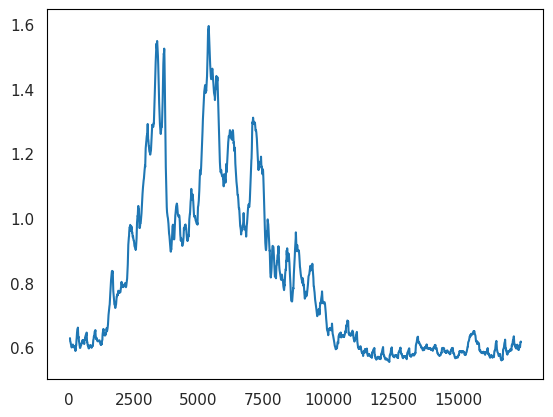

In [80]:
df_load.mean(axis=0).rolling(48).mean().plot()